# Analyzing Steam reviews (Russian language) sentiment with Bi-LSTM

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from steam_utils.sentiment_utils import *

In [3]:
# Reading data in a loop:

data_dir = 'steam_sentiment_data'
steam_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    
    tmp_data = pd.read_csv(f'{data_dir}/{filename}', sep=';', encoding='utf-8',
                           index_col=[0])
    
    steam_data = steam_data.append(tmp_data)
    
    steam_data.drop_duplicates(inplace=True)
    
    print(f'{filename}, Total Comments Loaded: {steam_data.shape[0]}, Batch Size: {tmp_data.shape[0]}')
    
    del tmp_data
    
steam_data.reset_index(drop=True, inplace=True)

steam_review_data_batch_53.csv, Total Comments Loaded: 17665, Batch Size: 17665
steam_review_data_batch_10.csv, Total Comments Loaded: 48818, Batch Size: 31153
steam_review_data_batch_27.csv, Total Comments Loaded: 78255, Batch Size: 29437
steam_review_data_batch_15.csv, Total Comments Loaded: 86633, Batch Size: 8378
steam_review_data_batch_17.csv, Total Comments Loaded: 101252, Batch Size: 14619
steam_review_data_batch_23.csv, Total Comments Loaded: 104450, Batch Size: 3198
steam_review_data_batch_3.csv, Total Comments Loaded: 107640, Batch Size: 3190
steam_review_data_batch_49.csv, Total Comments Loaded: 121168, Batch Size: 13528
steam_review_data_batch_7.csv, Total Comments Loaded: 135755, Batch Size: 14587
steam_review_data_batch_19.csv, Total Comments Loaded: 162001, Batch Size: 26246
steam_review_data_batch_12.csv, Total Comments Loaded: 204724, Batch Size: 42735
steam_review_data_batch_47.csv, Total Comments Loaded: 213473, Batch Size: 8750
steam_review_data_batch_52.csv, Total 

# Initial text pre-processing:

In [4]:
# Initial label and review cleaning
steam_data = (steam_data
              .assign(clean_label=lambda df: df.label.apply(lambda x: x.split('\n')[0]),
                      clean_review=lambda df: df.review.apply(clean_review)))

In [5]:
# Base text cleaning:
steam_data = (steam_data
              .assign(clean_review=lambda df: df.clean_review.apply(clean_text)))

In [6]:
# Filetring unrelevant reviews:
steam_data = (steam_data
              .assign(to_keep=lambda df: df.clean_review.apply(filter_reviews)))
# Applying filter:
steam_data = steam_data.query('to_keep > 0').drop(columns=['to_keep']).reset_index(drop=True)
# Resulting shape:
steam_data.shape

(1151361, 5)

In [7]:
# Constructing final text data:
steam_data_final = (steam_data
                    .assign(num_label=lambda df: df.clean_label.apply(to_num_y))
                    .loc[:, ['num_label', 'clean_review']]
                    .drop_duplicates()
                    .sample(frac=1)
                    .reset_index(drop=True))
# Saving the data:
# steam_data_final.to_csv('steam_data_final.csv', sep=';', encoding='utf-8')
# Resulting shape:
steam_data_final.shape

(1128236, 2)

In [ ]:
# Read file if needed:
# steam_data_final = pd.read_csv('steam_data_final.csv', sep=';', encoding='utf-8', index_col=0)

In [13]:
# Looking at some example rows:
steam_data_final.sample(frac=1).head(10)

,num_label,clean_review
35581,0,"запустил, настроил свое первое оружие и облик,..."
738152,0,отвратительный кусок кода собранный разработчи...
416818,0,в этой заметке хотелось бы написать не о самих...
184199,0,у меня пишет что невозможно открыть что за брет
135930,1,необычная и интересная идея игры. однозначно за.
428042,1,очень увлекательная игра\nза ч я побывал на оф...
714786,1,"круто, брутально, фантастически, сложно."
4679,1,крайне трогательная история в необычно красиво...
196984,0,"худшая игра, графика летней давности, натянули..."
154261,1,"ну у меня друзья не купили её, а так в шахматы..."


# Small glimpse at the data:

Here, by looking at training data, naive binary classification accuracy will be calculated as well as truncating length in tokens.

In [8]:
# naive guess accuracy baseline:
naive_guess = steam_data_final.num_label.sum() / steam_data_final.shape[0]
print(f'Naive guess accuracy is {naive_guess*100}%')

Naive guess accuracy is 84.03596410680035%


Mean review length is 62.65271007129714


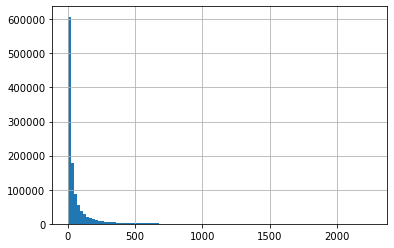

In [9]:
# Reviews length distribution
rev_len = steam_data_final.clean_review.apply(text_length)
print(f'Mean review length is {rev_len.mean()}')
rev_len.hist(bins=100)

In [10]:
# testing truncate length:
TRUNCATE_LEN = 400
print(f'{sum(rev_len <= TRUNCATE_LEN) / len(rev_len) * 100} % of reviews are below {TRUNCATE_LEN} threshold')

97.32130511701452 % of reviews are below 400 threshold


In [33]:
# Viewing sample random review:
rand_ind = np.random.choice(range(steam_data_final.shape[0]), 1, replace=False)[0]
sample_review = steam_data_final.clean_review[rand_ind]
print(sample_review)
sentiment_decode = {1: 'Positive', 0: 'Negative'}
print('------------------')
print('Review sentiment is {}'.format(sentiment_decode[steam_data_final.num_label[rand_ind]]))
print('Review length: {}'.format(len(sample_review.split(' '))))

atlas - ark: pirates. я говорю нет этой игре, не потому что здесь лаги и просто не понять что происходит на ранней версии. а потому что это не новая игра, а попросту мод на арк который хотят выдать как полноценно новый проект.
убивая аргументы тех кто играл в арк и хочет приобрести данный шедевр:
.) игру выпустила компания которая уже имеет бюджет и может сама без сбора средств выкатить нормальный проект
.) они по просту не постарались что то менять, взяли то что есть и вуаля играйте.
.) пишут что ммо, но ммо должно тебя тоже уметь развлекать, а не ты должен постоянно бегать и собирать ресурсы причем к как в арке. то есть это тот еще гемор.
.) костомизация персонажей прекрасна, вы опять постарались арков из
------------------
Review sentiment is Negative
Review length: 122


# Text tokenization:

For converting text to tokens BPE tokenizer was used. Among the advantages of such tokenization technique are:
1. Speed (much faster than lemmatization for example)
2. Possibility to model and account for morphology
3. No need for OOV token

In [12]:
# Preparing training data for tokenizer:
train_data_path = "train_data.txt"
with open(train_data_path, "w", encoding='utf-8') as fout:
    for rev in range(steam_data_final.shape[0]):
        print(steam_data_final.clean_review[rev], end='\n', file=fout)

In [37]:
# Training tokenizer:
VOCAB_SHAPE = 7500
model_path = "russian_steam_review_model/steam_tokenizer.model"
# yttm.BPE.train(data=train_data_path, vocab_size=VOCAB_SHAPE, model=model_path)

In [38]:
# Loading the model
steam_bpe = yttm.BPE(model=model_path)

In [39]:
# Looking at the vocabulary:
print(len(steam_bpe.vocab()))
print(*steam_bpe.vocab()[-500:])

7500
щер ▁соответственно ▁da ▁фишка вок, ly ▁подобра кера джет ▁хрень ▁приходит ▁преми ▁лагер ▁a. ▁шах ▁бру ▁заключается нию, кви ▁очков ▁сомне ▁зом нейшая ▁высоте. шему ▁восхити ▁имхо ▁vr ▁теку ▁скины ▁будет, ▁новел ▁рейтинг ▁вариант игры ▁фору ▁разда чкой ▁наблюдать ▁приобрет ▁нашёл ▁лучшие ▁edition ▁перепрой ▁трени ▁преле ▁доку ▁плюс, ▁чувства ▁тюрь ▁достойна лу. нику ▁внезапно бежать ▁проник ▁существует ▁поддержка ▁убей ▁твоего ▁подобные ▁юбисо ▁con нулся ▁имени ▁улучши мон ▁идите ▁желаю лки, вающие ▁запускается ▁солдат ёрт ▁муж ▁история. ▁кастомизация ▁мяс прин ▁arkham ▁мультиплеер, ▁), гой ▁htt ▁симпати кля ▁спасибо, ▁себе. тии ▁что? ▁shad -с зировать ▁головой ▁подоби ▁аф ▁проя ▁миссию ▁во-вторы ▁будьте ▁дарк нность ▁вру ▁минусов: ▁напомни ▁локаций, лом. ▁скачал ▁персонажи. ▁заслужи щет ▁команде ▁редактор ▁производи '' ▁проси ▁однообрази ▁сплош ▁тупа лое ▁сдох ▁получше чек, ann ▁dlc, то, ▁государ емый ▁отобра ▁самолё ▁заставит жка ▁большого ▁форма ▁участ ▁заб ▁библиоте ▁линия ▁су

In [40]:
# Tokenise sample review:
print(steam_bpe.encode(sample_review, output_type=yttm.OutputType.ID))
print(steam_bpe.encode(sample_review, output_type=yttm.OutputType.SUBWORD))

[4, 1369, 53, 1446, 601, 5512, 52, 1000, 3645, 1369, 1216, 28, 611, 5993, 800, 906, 2008, 543, 1275, 588, 1100, 6848, 527, 721, 543, 3526, 588, 3077, 549, 1507, 1061, 1731, 1933, 583, 1275, 588, 591, 543, 3800, 1044, 583, 6450, 5280, 549, 1192, 15, 1054, 4783, 603, 1463, 642, 2796, 36, 786, 2392, 1776, 1097, 974, 904, 1192, 922, 6933, 1219, 1005, 1401, 529, 1192, 15, 527, 3328, 7262, 2257, 2759, 52, 720, 42, 693, 4265, 562, 5092, 1328, 857, 2333, 6511, 7008, 527, 977, 1370, 933, 530, 4930, 6806, 603, 557, 1528, 5328, 3512, 720, 42, 909, 539, 569, 1011, 543, 4133, 1056, 588, 585, 811, 792, 2473, 548, 585, 588, 738, 527, 6962, 7, 599, 3228, 28, 720, 42, 5918, 588, 4273, 24, 587, 4273, 3498, 1178, 1170, 2721, 538, 621, 1879, 792, 583, 543, 807, 2676, 1886, 4018, 527, 4753, 5805, 3569, 534, 642, 529, 1192, 1904, 585, 738, 591, 1642, 892, 594, 1638, 1780, 720, 42, 568, 617, 3808, 973, 1988, 1429, 1386, 603, 2387, 4133, 1056, 1192, 770, 631]
['▁', 'at', 'l', 'as', '▁-', '▁ark', ':', '▁p', 'i

# Data numerification:

In [23]:
# converting to number tokens with tokenizer:
list_num_tokens = steam_bpe.encode(steam_data_final.clean_review.to_list(), output_type=yttm.OutputType.ID)
len(list_num_tokens)

1128236

In [24]:
# padding & truncating sequences
PAD = 'post'
TRUNCATE = 'post'
X_steam = tf.keras.preprocessing.sequence.pad_sequences(list_num_tokens, maxlen=TRUNCATE_LEN, 
                                                        padding=PAD, truncating=TRUNCATE)
y_steam = np.array(steam_data_final.num_label.to_list())

In [25]:
X_steam.shape, y_steam.shape

((1128236, 400), (1128236,))

In [26]:
# Split into train, val and test:
X_train, X_test, y_train, y_test = train_test_split(X_steam, y_steam, test_size=50000/X_steam.shape[0], random_state=1,
                                                    stratify=y_steam)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=50000/X_train.shape[0], random_state=1,
                                                  stratify=y_train) 

In [27]:
# Looking at the data stats:
print(f'Train X shape: {X_train.shape}', 
      f'Validation X shape: {X_val.shape}', 
      f'Test X shape: {X_test.shape}', sep='\n', end='\n\n')

print(f'Train y shape: {y_train.shape}', 
      f'Validation y shape: {y_val.shape}', 
      f'Test y shape: {y_test.shape}', sep='\n', end='\n\n')

print(f'Train naive acc: {y_train.sum() / len(y_train)}', 
      f'Validation naive acc: {y_val.sum() / len(y_val)}', 
      f'Test naive acc: {y_test.sum() / len(y_test)}', sep='\n')

Train X shape: (1028236, 400)
Validation X shape: (50000, 400)
Test X shape: (50000, 400)

Train y shape: (1028236,)
Validation y shape: (50000,)
Test y shape: (50000,)

Train naive acc: 0.8403596061604535
Validation naive acc: 0.84036
Test naive acc: 0.84036


In [28]:
# Converting to TF data:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 1024
SHUFFLE_BUFFER_SIZE = 4098

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

# Specifying model:

For text classification bidirectional LSTM many to one architecture is used. Before passing to LSTM layer tokens are embedded, after LSTM layer dimensionality is reduced with global max pooling.

In [29]:
# bulding LSTM many to one model:
EMBED_SIZE = 128 #128
def create_rsr_net():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input([TRUNCATE_LEN]),
        tf.keras.layers.Embedding(VOCAB_SHAPE, EMBED_SIZE),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)), #128
        tf.keras.layers.GlobalMaxPool1D(),
        tf.keras.layers.Dense(128, activation='relu'), # 128
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [30]:
RSRNet = create_rsr_net()
RSRNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 128)          960000    
_________________________________________________________________
bidirectional (Bidirectional (None, 400, 256)          263168    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,256,193
Trainable params: 1,256,193
Non-trainable params: 0
______________________________________________

In [31]:
# Create checkpoints:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="rsr_test/rsr_test_ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)
# Compile the model:
RSRNet.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=[tf.keras.metrics.BinaryAccuracy(),
                        tf.keras.metrics.AUC(curve='ROC', name='auc_roc'),
                        tf.keras.metrics.AUC(curve='PR', name='auc_prc')])

In [32]:
# Setting the device:
device = '/device:GPU:0'

In [33]:
# Training the model:
with tf.device(device):
    history = RSRNet.fit(train_dataset, epochs=3, validation_data=val_dataset, callbacks=[cp_callback])

Epoch 1/3
1005/1005 [==============================] - ETA: 0s - loss: 0.2364 - binary_accuracy: 0.9044 - auc_roc: 0.9239 - auc_prc: 0.9831
Epoch 00001: saving model to rsr_test_ckpt
1005/1005 [==============================] - 454s 451ms/step - loss: 0.2364 - binary_accuracy: 0.9044 - auc_roc: 0.9239 - auc_prc: 0.9831 - val_loss: 0.1980 - val_binary_accuracy: 0.9196 - val_auc_roc: 0.9508 - val_auc_prc: 0.9893
Epoch 2/3
1005/1005 [==============================] - ETA: 0s - loss: 0.1882 - binary_accuracy: 0.9246 - auc_roc: 0.9537 - auc_prc: 0.9898
Epoch 00002: saving model to rsr_test_ckpt
1005/1005 [==============================] - 452s 450ms/step - loss: 0.1882 - binary_accuracy: 0.9246 - auc_roc: 0.9537 - auc_prc: 0.9898 - val_loss: 0.1892 - val_binary_accuracy: 0.9255 - val_auc_roc: 0.9539 - val_auc_prc: 0.9895
Epoch 3/3
1005/1005 [==============================] - ETA: 0s - loss: 0.1723 - binary_accuracy: 0.9315 - auc_roc: 0.9616 - auc_prc: 0.9915
Epoch 00003: saving model to rsr

# Evaluating the quality on test dataset:

In [34]:
# Evaluating the model on test dataset:
test_evaluate = RSRNet.evaluate(test_dataset)

49/49 [==============================] - 7s 141ms/step - loss: 0.1912 - binary_accuracy: 0.9240 - auc_roc: 0.9519 - auc_prc: 0.9891


In [35]:
# Plot error table:
y_test_fit = RSRNet_predict(RSRNet, X_test, batch_size=1024)
y_test_fit_disc = (y_test_fit > 0.5).astype('int32').reshape(-1)
print('Accuracy is: {}'.format((y_test_fit_disc == y_test).sum() / len(y_test)))
print('AUC ROC is : {}'.format(roc_auc_score(y_test, y_test_fit)))

Accuracy is: 0.92398
AUC ROC is : 0.9527559071669646


In [36]:
# Error Matrix:
confusion_matrix(y_test, y_test_fit_disc)

array([[ 5482,  2500],
       [ 1301, 40717]])

# Refit on the entire data:

In [37]:
# Converting to TF data:
steam_dataset = tf.data.Dataset.from_tensor_slices((X_steam, y_steam))

BATCH_SIZE = 1024
SHUFFLE_BUFFER_SIZE = 4098

steam_dataset = steam_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [38]:
RSRNet = create_rsr_net()

In [39]:
# Compile the model:
RSRNet.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=[tf.keras.metrics.BinaryAccuracy(),
                        tf.keras.metrics.AUC(curve='ROC', name='auc_roc'),
                        tf.keras.metrics.AUC(curve='PR', name='auc_prc')])

In [40]:
# Training the model:
with tf.device(device):
    history = RSRNet.fit(steam_dataset, epochs=3)

Epoch 1/3
1102/1102 [==============================] - 489s 444ms/step - loss: 0.2347 - binary_accuracy: 0.9052 - auc_roc: 0.9251 - auc_prc: 0.9834
Epoch 2/3
1102/1102 [==============================] - 488s 443ms/step - loss: 0.1871 - binary_accuracy: 0.9252 - auc_roc: 0.9543 - auc_prc: 0.9899
Epoch 3/3
1102/1102 [==============================] - 488s 443ms/step - loss: 0.1716 - binary_accuracy: 0.9317 - auc_roc: 0.9618 - auc_prc: 0.9916


In [41]:
# Saving the model:
# saving model to file:
RSRNet.save('RSRNet.h5')

# Playing with fit:

In [9]:
import pandas as pd
from steam_utils.sentiment_utils import *

In [10]:
# Loading model:
RSRNet = tf.keras.models.load_model('russian_steam_review_model/RSRNet.h5')
# Loading tokenizer:
steam_bpe = yttm.BPE(model='russian_steam_review_model/steam_tokenizer.model')
# Define scorer:
steam_scorer = ScoreReview(tokenizer=steam_bpe, score_net=RSRNet,
                           pad='post', truncate='post', truncate_len=400)

In [14]:
sample_texts = ['Удалил спустя пару часов. Это просто невыносимо',
                'Эта игра настоящий шедевр! Она взорвала мои моооозгииии',
                'Одни баги, игра постоянно вылетает',
                'Захватывающий сюжет и интересный геймплей',
                'Отлично, если не играть',
                'Графон мыльный, куча доната и микротранзакций',
                'Динамичная боевка, наполненный открытый мир',
                'Зависает в главном меню',
                'Мой компьютер не потянет эту игру',
                'Вернул деньги',
                'Кидаю деньги в монитор',
                'В игре много минусов и их перечисление займет гораздо больше времени чем я наиграл в нее, благо самый главный минус встречает игрока на первых 3мин. - в игре за 435-500 нельзя поменять управление. Своих денег не стоит.P.S. Я прекрасно понимаю, что это игра от инди разрабов, но это не оправдание для такой кучи ошибок со стороны тех. и дизайнерской частей',
                'Для меня серия Ghost Recon закончилась на Tom Clancy’s Ghost Recon: Future Soldier, дальше же пошёл какой то шлак',
                'Не работают сервера',
                '1:54 меня этим и подкупила, что все смешали, мне вкатило.',
                'Юбисофт опять обманули, ничего удивительного.',
                'Если честно не советую вам покупать, графика хорошая, движок тоже норм, но баги не перечислить!',
                'Я, уже 6 числа купил долгая игруля и норм игра но баги есть !)',
                'Игра понравилась. Тот случай, когда обзоры неверное впечатление об игре передают. Игру бы слегка отбалансить, чтоб стелс по идиотски  не ломать временами.',
                'Бета была многообещающей, но в финальную версию всё так же тяжело играть. Для динамики данной игры одна смерть (после которой ты возвращаешься к истокам) - наказание, а не вызов. Потому что прохождение занимает очень длительное время. Медленный бег по коридорам, отсутствие быстрых перемещений, очень долгий подъем по лестницам, перекаты по столам и т.д. (Кто-то уже писал, что перечисление минусов займет больше времени, чем я наиграл) Да крутой жанр, крутой стиль, ничего не испортится ускорением игрового процесса, это ведь рогалик.Спасибо за огромную скидку для бета-тестеров, вряд ли я когда-нибудь запущу эту игру снова.И крайне не советую покупать игру (а уж тем более DLC) за заявленные деньги. Только по скидке или бесплатно (пока что).Я обязательно изменю свой отзыв, когда увижу обновление хотя бы по перемещению.',
                'Зря потратил время на эту игру',
                'Судя по трейлерам, крутой блокбастер, но геймплей однообразный',
                'Офигеть, какая игра',
                'Ну что это за игра',
                'Чудесная и великолепная графика, красивые закаты, интересная механика игры на гитаре, но слишком скучное и монотонное развитие сюжета, это портит все впечатление, скучно.',
                'Видно в комментах люди уже не верят в игру. Оно и не удивительно, ведь столько обманов от юбисофт. Но я лично, верю что игра будет достойной',
                'Скорее бы уже вышла! После цусими не во что играть(( ну разве что ремейк мафии, но там часов на 20 максимум, а здесь залипнуть хоть можно и погрузиться))',
                'Мда. Викинги никак не могут быть в списках ассасинов. Это вообще никак не вписывается. От ассасинов осталось только название, прежде всего ассасины это утончëнные и бесшумные убийцы, а не это дерьмо. Было бы лучше если бы эта игра называлась просто вальгала но никак не ассасин...'] # actual Youtube

In [15]:
score, label, sentiment = steam_scorer.predict(sample_texts)

In [16]:
pd.DataFrame({'sample_review': sample_texts,
              'score': score,
              'label': label,
              'sentiment': sentiment})

,sample_review,score,label,sentiment
0,Удалил спустя пару часов. Это просто невыносимо,0.311001,0,Negative
1,Эта игра настоящий шедевр! Она взорвала мои мо...,0.995141,1,Positive
2,"Одни баги, игра постоянно вылетает",0.061664,0,Negative
3,Захватывающий сюжет и интересный геймплей,0.997844,1,Positive
4,"Отлично, если не играть",0.925283,1,Positive
5,"Графон мыльный, куча доната и микротранзакций",0.101197,0,Negative
6,"Динамичная боевка, наполненный открытый мир",0.994680,1,Positive
7,Зависает в главном меню,0.207798,0,Negative
8,Мой компьютер не потянет эту игру,0.894053,1,Positive
9,Вернул деньги,0.258352,0,Negative
